# LSTM model for sentiment Analysis

In [40]:
import joblib
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', 180)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

## Read the embeddings and Labels

In [41]:
X_train = joblib.load('train_embeddings.pkl')
y_train = pd.read_csv('training.csv')['label'].values

X_val = joblib.load('validation_embeddings.pkl')
y_val = pd.read_csv('validation.csv')['label'].values

X_test = joblib.load('test_embeddings.pkl')
y_test = pd.read_csv('test.csv')['label'].values

In [42]:
train = pd.read_csv('training.csv')
train.head()
#train[train.duplicated('text', keep=False)].sort_values(by='text')

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,2
4,i am feeling grouchy,3


## Number of classes or emotions

In [43]:
print("Unique labels in training set:", np.unique(y_train))
print("Min label:", np.min(y_train))
print("Max label:", np.max(y_train))

Unique labels in training set: [0 1 2 3 4 5]
Min label: 0
Max label: 5


In [44]:
X_train.shape, y_train.shape

((16000, 768), (16000,))

In [45]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

## Convert the data into Dataset and DataLoader



In [46]:
class EmotionDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings  # Lista de embeddings generados por RoBERTa
        self.labels = labels.squeeze()  # Lista de etiquetas

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [47]:
# Dataset type conversion
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
test_dataset = EmotionDataset(X_test, y_test)

# DataLoaderr to make use of batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [48]:
type(train_dataset), type(train_loader)

(__main__.EmotionDataset, torch.utils.data.dataloader.DataLoader)

## LSTM Model

Parameters:
- Input_size: Embeddings size
- Hidden_size: Number of neurons in the LSTM
- num_layers: Number of stacking LSTM
- output_size: number of emotions or classes

In [54]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # LSTM
    self.lstm = nn.LSTM(
        input_size,
        hidden_size,
        num_layers,
        dropout=dropout,
        batch_first=True
    )

    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, hidden_size // 2),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size // 2, hidden_size//4),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_size//4, output_size)
    )


  def forward(self, x):
    if len(x.shape) == 2:
      x = x.unsqueeze(1)  # Agrega dimensión de secuencia (batch_size, 1, embedding_dim)

    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

    # LSTM output: output of all the hidden_state, hidde_state, cell_state
    lstm_out, (hidden, _) = self.lstm(x, (h0,c0))
    # out: batch_size, seq_length, hidden_state

    # Classification layers
    output = self.classifier(lstm_out[:, -1, :])
    return output

### Entrenar y Evaluar

In [50]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=20, patience=5, device="cpu"):
    best_val_f1 = 0
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_predictions = []
        train_true_labels = []

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            # Forward
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions for F1-score
            predictions = torch.argmax(outputs, dim=1)
            train_predictions.extend(predictions.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Calculate Training F1-score
        train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')
        train_f1_scores.append(train_f1)

        # Validation phase
        model.eval()
        val_predictions = []
        val_true_labels = []
        val_loss = 0

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)

                # Calculate loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Store predictions for F1-score
                predictions = torch.argmax(outputs, dim=1)
                val_predictions.extend(predictions.cpu().numpy())
                val_true_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate Validation F1-score
        val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
        val_f1_scores.append(val_f1)

        # Print epoch results
        if epoch %10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Training Loss: {avg_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
            print(f"Training F1-Score: {train_f1:.4f} | Validation F1-Score: {val_f1:.4f}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        scheduler.step()

    return train_losses, val_losses, train_f1_scores, val_f1_scores


In [51]:
def plot_training_curves(train_losses, val_losses, train_f1_scores, val_f1_scores):
    plt.figure(figsize=(14, 6))

    # Losses (Training and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # F1-scores (Training and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(train_f1_scores, label='Training F1-Score')
    plt.plot(val_f1_scores, label='Validation F1-Score')
    plt.title('Training and Validation F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()


### Hiperparámetros

In [55]:
embedding_dim = 768  # Embedding size
hidden_dim = 256
output_dim = 6  # Number of emotion or classes
num_layers = 2
dropout = 0.45

# Model
model = LSTM(embedding_dim, hidden_dim, num_layers, output_dim, dropout)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses, train_f1_scores, val_f1_scores = train_and_evaluate(
    model, train_loader, val_loader, criterion, optimizer, epochs=200, patience=5
)

Epoch 1/200
Training Loss: 1.3226 | Validation Loss: 1.1718
Training F1-Score: 0.4278 | Validation F1-Score: 0.4813
Epoch 11/200
Training Loss: 0.8983 | Validation Loss: 0.8773
Training F1-Score: 0.6602 | Validation F1-Score: 0.6694
Epoch 21/200
Training Loss: 0.8068 | Validation Loss: 0.8216
Training F1-Score: 0.6953 | Validation F1-Score: 0.6899
Epoch 31/200
Training Loss: 0.7821 | Validation Loss: 0.8085
Training F1-Score: 0.7097 | Validation F1-Score: 0.7040
Early stopping triggered


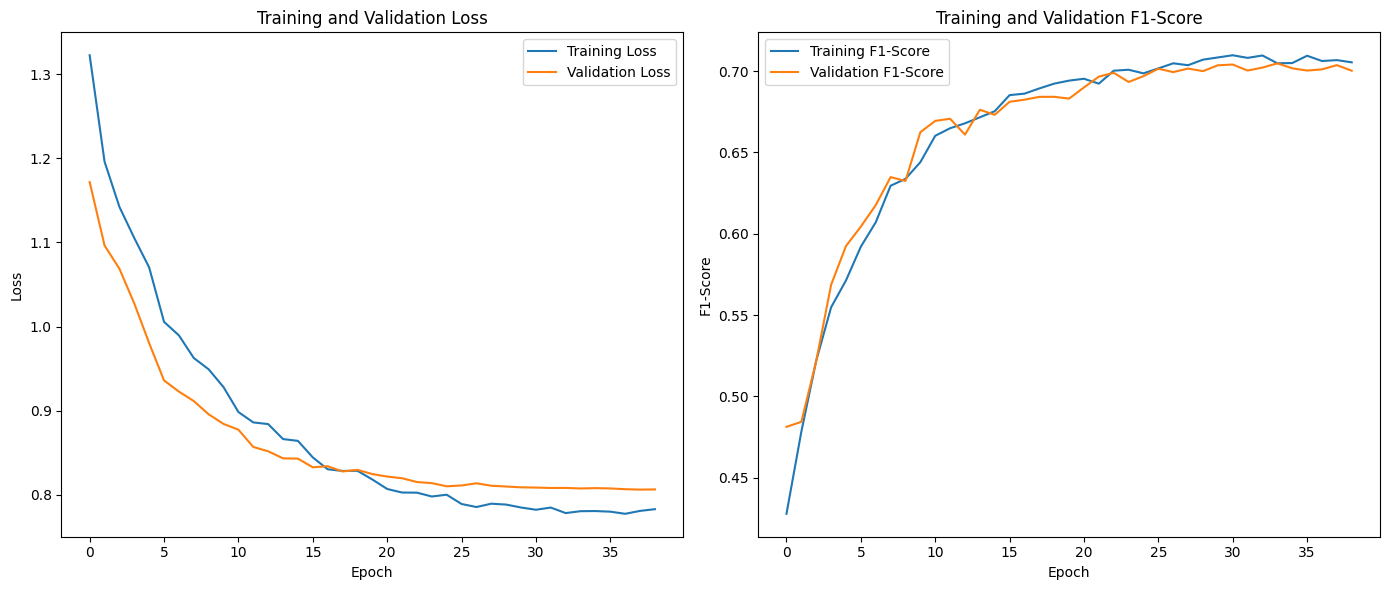

In [56]:
plot_training_curves(train_losses, val_losses, train_f1_scores, val_f1_scores)

## Predicciones

In [57]:
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F # Import F

class TextPredictionPipeline:
    def __init__(self, lstm_model, device='cpu'):
        # Cargar el modelo LSTM entrenado
        self.lstm_model = lstm_model
        self.lstm_model.to(device)
        self.lstm_model.eval()

        # Cargar tokenizer y modelo
        self.tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
        self.model.to(device)
        self.model.eval()
        self.device = device

        # Mapeo de etiquetas
        self.label_mapping = {
            0: "sadness",
            1: "joy",
            2: "love",
            3: "anger",
            4: "fear",
            5: "surprise"
        }

    def get_embedding(self, text):
        """Obtiene el embedding para un texto."""
        with torch.no_grad():
            # Tokenizar el texto
            inputs = self.tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(self.device)

            # Obtener embeddings
            outputs = self.model(**inputs)

            # Usar el embedding del token [CLS] (primer token)
            embeddings = outputs.last_hidden_state[:, 0, :]

            return embeddings

    def predict(self, text, return_probabilities=False):
        """
        Realiza una predicción para un texto dado.

        Args:
            text (str): Texto a clasificar
            return_probabilities (bool): Si es True, devuelve las probabilidades para cada clase

        Returns:
            str: Etiqueta predicha
            dict: Probabilidades por clase (opcional)
        """
        # Obtener embedding
        embedding = self.get_embedding(text)

        # Realizar predicción con el modelo LSTM
        with torch.no_grad():
            outputs = self.lstm_model(embedding)
            probabilities = F.softmax(outputs, dim=1) # Use F

            # Obtener la predicción
            predicted_class = torch.argmax(probabilities, dim=1).item()
            predicted_label = self.label_mapping[predicted_class]

            if return_probabilities:
                # Convertir probabilidades a diccionario
                probs_dict = {
                    label: prob.item()
                    for label, prob in zip(self.label_mapping.values(), probabilities[0])
                }
                return predicted_label, probs_dict

            return predicted_label

    def predict_batch(self, texts, return_probabilities=False):
        """
        Realiza predicciones para una lista de textos.

        Args:
            texts (list): Lista de textos a clasificar
            return_probabilities (bool): Si es True, devuelve las probabilidades para cada clase

        Returns:
            list: Lista de etiquetas predichas
            list: Lista de diccionarios con probabilidades (opcional)
        """
        # Obtener embeddings para todos los textos
        embeddings = torch.cat([self.get_embedding(text) for text in texts])

        # Realizar predicciones
        with torch.no_grad():
            outputs = self.lstm_model(embeddings)
            probabilities = F.softmax(outputs, dim=1) # Use F

            # Obtener predicciones
            predicted_classes = torch.argmax(probabilities, dim=1)
            predicted_labels = [self.label_mapping[cls.item()] for cls in predicted_classes]

            if return_probabilities:
                # Convertir probabilidades a lista de diccionarios
                probs_list = [
                    {label: prob.item() for label, prob in zip(self.label_mapping.values(), probs)}
                    for probs in probabilities
                ]
                return predicted_labels, probs_list

            return predicted_labels

In [58]:
pipeline = TextPredictionPipeline(model, device='cpu')

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
# Hacer predicción para un solo texto
texto = "I am very happy"
prediccion = pipeline.predict(texto)
print(f"Emoción predicha: {prediccion}")

Emoción predicha: joy


In [60]:
# Obtener predicción con probabilidades
prediccion, probabilidades = pipeline.predict(texto, return_probabilities=True)
print(f"Emoción predicha: {prediccion}")
print("Probabilidades por clase:")
for emocion, prob in probabilidades.items():
    print(f"{emocion}: {prob:.4f}")

Emoción predicha: joy
Probabilidades por clase:
sadness: 0.0000
joy: 0.9973
love: 0.0027
anger: 0.0000
fear: 0.0000
surprise: 0.0000


In [61]:
# Hacer predicciones para varios textos a la vez
textos = [
    "I hate the sun",
    "I am very sad",
    "omg I can not believe it"
]
predicciones = pipeline.predict_batch(textos)
for texto, pred in zip(textos, predicciones):
    print(f"\nTexto: {texto}")
    print(f"Emoción predicha: {pred}")


Texto: I hate the sun
Emoción predicha: anger

Texto: I am very sad
Emoción predicha: sadness

Texto: omg I can not believe it
Emoción predicha: surprise


## Save the model

In [62]:
model_save_path = 'modelo_emociones.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Modelo guardado en: {model_save_path}")

Modelo guardado en: modelo_emociones.pth
